In [91]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
from datetime import timedelta
import numpy as np

import matplotlib.dates as mdates

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

from numpy.polynomial.polynomial import polyfit

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels
#import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS



import warnings
warnings.filterwarnings("ignore")

In [92]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"


In [93]:

file_path = os.getcwd()

#trade_county = pq.read_table(file_path + "\\data\\trade_employment_goods.parquet").to_pandas()

trade_county = pq.read_table(file_path + "\\data\\trade_employment_2014.parquet").to_pandas()

In [94]:
trade_county["time"] = pd.to_datetime(trade_county.time)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [95]:
trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_total"] = np.log(trade_county["total_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_exp_china"] = np.log(trade_county["china_exp_pc"]).replace(-np.inf, np.nan)

emp_measure = "emp_all"
# Here you specify the type of employment you want. emp_all is total employment. emp_gds = goods employment. 

trade_county["log_employment"] = np.log(trade_county[emp_measure]).replace(-np.inf, np.nan)
# Now given how the file is setup, we can select which type of employment.
# all private, goods, or manufacturing.

#trade_county["log_employment"] = np.log(trade_county["emp_all"] - 
                                        #trade_county["emp_gds"]).replace(-np.inf, np.nan)

# Here is the issue, if you just subtract stuff, there are some missing observations relative
# to the direct look at non-goods employment ('use emp_n_gds'). So the later is appears 
# better, though you can find instances where this approach above delivers values, compramise
# would be to ``fill in'' things...safest is always just look at total employment; any break
# down starts to get into these issues.

trade_county["const"] = 1

In [96]:
trade_county.reset_index(inplace = True)

trade_county.rename({"area_fips": "GEOFIPS"},axis = 1, inplace = True)

trade_county["state_fips"] = trade_county["GEOFIPS"].astype(str).str[0:2]

trade_county["GEOFIPS"] = trade_county["GEOFIPS"].astype(int)

In [97]:
trade_county.set_index(["GEOFIPS", "time"], inplace = True)

In [98]:
trade_county.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017  fips  \
GEOFIPS time                                                                  
10001   2014-01-01           NaN           NaN  1.069526          NaN  None   
        2014-02-01           NaN           NaN  1.069526          NaN  None   
        2014-03-01           NaN           NaN  1.069526          NaN  None   
        2014-04-01           NaN           NaN  1.069526          NaN  None   
        2014-05-01           NaN           NaN  1.069526          NaN  None   

                    total_employment  emp_all  emp_gds  emp_n_gds  \
GEOFIPS time                                                        
10001   2014-01-01           29514.0      0.0      0.0    37089.0   
        2014-02-01           29514.0      0.0      0.0    37024.0   
        2014-03-01           29514.0      0.0      0.0    37254.0   
        2014-04-01           29514.0      0.0      0.0    37875.0   
        2014-05-01           29514.0      0.0      0.0    38005.0   

                    rural_share  2010_population  2017_income  \
GEOFIPS time                                                    
10001   2014-01-01     0.269694         162310.0      57647.0   
        2014-02-01     0.269694         162310.0      57647.0   
        2014-03-01     0.269694         162310.0      57647.0   
        2014-04-01     0.269694         162310.0      57647.0   
        2014-05-01     0.269694         162310.0      57647.0   

                    2017_population  log_tariff  log_exp_total  log_exp_china  \
GEOFIPS time                                                                    
10001   2014-01-01         173145.0    0.010638            NaN            NaN   
        2014-02-01         173145.0    0.010638            NaN            NaN   
        2014-03-01         173145.0    0.010638            NaN            NaN   
        2014-04-01         173145.0    0.010638            NaN            NaN   
        2014-05-01         173145.0    0.010638            NaN            NaN   

                    log_employment  const state_fips  
GEOFIPS time                                          
10001   2014-01-01             NaN      1         10  
        2014-02-01             NaN      1         10  
        2014-03-01             NaN      1         10  
        2014-04-01             NaN      1         10  
        2014-05-01             NaN      1         10

In [99]:
# First take growth rates

# note , I'm a bit confused about why the sorting,
# here is that because of some missing values, the resulting dateframe from the 
# first operation may be out of place, so we need to resort things to make sure that
# the time difference is correct.
trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["tariff_change"] = trade_county.groupby(["GEOFIPS"]).tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["log_tariff_change"] = trade_county.groupby(["GEOFIPS"]).log_tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["total_trade_growth"] = trade_county.groupby(["GEOFIPS"]).log_exp_total.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["china_trade_growth"] = trade_county.groupby(["GEOFIPS"]).log_exp_china.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

In [100]:
trans = lambda df: df.iloc[-1]

#trade_county.groupby(["GEOFIPS"]).log_tariff.transform(trans)

trade_county["lead_tariff"] = trade_county.groupby(["GEOFIPS"]).log_tariff_change.transform(trans)

In [101]:
trade_county["man_share"] = trade_county["emp_gds"] / trade_county["emp_all"]

trade_county["man_share"] = trade_county["man_share"].replace(np.inf, np.nan)

In [102]:
trans = lambda df: df.iloc[0:11].mean()

#trade_county.groupby(["GEOFIPS"]).log_tariff.transform(trans)

trade_county["avg_man_share"] = trade_county.groupby(["GEOFIPS"]).man_share.transform(trans)

In [103]:
trade_county["avg_man_share"].mean()

0.2765242448019365

In [104]:
years = [17,18,19]

quarters = [[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]]

#quarters = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]]

rural_list = []

man_list = []

tariff_list = []

count = 0

event_study = pd.DataFrame([])

for xxx in years:
    
    for yyy in quarters:
        
        if (xxx == 19) & (yyy[0] > 3):
            break
            
        
        year = "20" + str(xxx)
        year = int(year)
        
        date_cond = ((trade_county.index.get_level_values(1).month.isin(yyy)) 
             & (trade_county.index.get_level_values(1).year == year ))
        
        name = "M" + str(yyy) + "_" + str(xxx)
        
        print(name)
        
        if count == 0:
            
            event_study = pd.merge(trade_county.reset_index(),
                                   pd.get_dummies(date_cond)[1].rename(name),
                                   left_index = True, right_index= True)
        else:
            
            event_study = pd.merge(event_study, 
                       pd.get_dummies(date_cond)[1].rename(name),
                                   left_index = True, right_index= True)
               
        name_t = name + "_t"
        
        name_r = name + "_r"
        
        name_m = name + "_m"
        
        event_study[name_t] = event_study.lead_tariff.multiply(event_study[name], axis = 0)
        # This will be the dummy variable on the leads

        event_study[name_r] = event_study.rural_share.multiply(event_study[name], axis = 0)
         # This will be the dummy variable on ineraction with rural share

        event_study[name_m] = event_study.avg_man_share.multiply(event_study[name], axis = 0) 
        # This will be the dummy variable on ineraction with goods employment share
        
        count = count + 1
        
        tariff_list.append(name_t)
        
        man_list.append(name_m)
        
        rural_list.append(name_r)
        
        print(count)
        
######################################################## 
        
event_study.set_index(["GEOFIPS", "time"],inplace = True)

M[1, 2]_17
1
M[3, 4]_17
2
M[5, 6]_17
3
M[7, 8]_17
4
M[9, 10]_17
5
M[11, 12]_17
6
M[1, 2]_18
7
M[3, 4]_18
8
M[5, 6]_18
9
M[7, 8]_18
10
M[9, 10]_18
11
M[11, 12]_18
12
M[1, 2]_19
13
M[3, 4]_19
14


In [105]:
all_vars = ["const", "log_tariff_change", 'employment_growth', "total_employment", "total_trade_growth",
           "avg_man_share", "rural_share", "2017_population"]

all_vars.extend(tariff_list)

all_vars.extend(man_list)

all_vars.extend(rural_list)
            
idx = pd.IndexSlice

#weights = trade_county["emplvl_2017"].loc[idx[:,"2018-01-01":"2019-02-01"]]

dataset = event_study[all_vars].loc[idx[:,"2017-01-01":"2019-4-01"],:]

exog_vars = ["const"]

exog_vars.extend(tariff_list)

exog_vars.extend(man_list)

exog_vars.extend(rural_list)

weights = dataset["2017_population"].to_frame()

weights.replace(to_replace = 0, value = 0.001,inplace = True)

print(weights.shape)
print(dataset.employment_growth.shape)

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

(87804, 1)
(87804,)
27
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0262
Estimator:                   PanelOLS   R-squared (Between):              0.0376
No. Observations:               84135   R-squared (Within):              -0.0064
Date:                Tue, Nov 12 2019   R-squared (Overall):              0.0156
Time:                        05:56:47   Log-likelihood                 1.955e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      853.47
Entities:                        3125   P-value                           0.0000
Avg Obs:                       26.923   Distribution:                F(42,84066)
Min Obs:                       3.0000                                           
Max Obs:                       27.000   F-statistic (robust):             7.5674


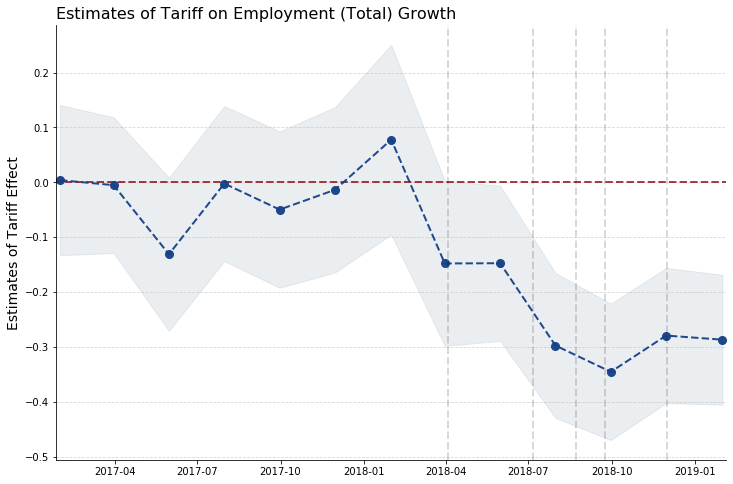

In [106]:
test2 = fe_res.conf_int(level=0.90).iloc[1:14].merge(fe_res.params, left_index = True, right_index = True)

start = dt.datetime(2017,1,1)
end = dt.datetime(2019,3,1)

test2.index = pd.date_range(start=start, end=end, freq = "2M")

#########################################################################

fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot(test2.parameter, alpha = 0.95, color = mike_blue, linewidth = 2, linestyle= "--",
       marker='o', markersize = 8)

ax.fill_between(test2.index, test2.lower, test2.upper, color = "#3F5D7D", alpha = 0.1)

ax.set_ylabel('Estimates of Tariff Effect', fontsize = 14)

ax.set_title("Estimates of Tariff on Employment (Total) Growth", fontsize = 16, loc= "left" )

ax.hlines(0, start, end,
           linewidth = 2, color = 'darkred', alpha =0.75, linestyle = "--")

#ax.set_ylim(-1.5,0.75)

ax.set_xlim(test2.index[0]- timedelta(4),test2.index[-1] + timedelta(4))

months = mdates.MonthLocator((1,4,7,10))
ax.xaxis.set_major_locator(months)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\employment_all_pretrend.pdf", bbox_inches = "tight", dip = 3600)